In [1]:
import os 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [50]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(60, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, 1)
        
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
    
device = torch.device("cuda")
net = Net().to(device)
print(net)

Net(
  (fc1): Linear(in_features=60, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=60, bias=True)
  (fc4): Linear(in_features=60, out_features=1, bias=True)
)


In [46]:
speedProfile = np.genfromtxt('test_CF.csv', delimiter=',')
#first pair for train
leader = speedProfile[:,0]
follower = speedProfile[:,1]
IVS1 = speedProfile[:,3]

#second pair for test
follower2 = speedProfile[:,2]
IVS2 = speedProfile[:,4]


#input 20s speed profiles (200 data points) of leader and ego
#output next speed point of me
trainX, trainY, testX, testY = [], [], [], []
for i in range(len(leader) - 21):
    trainX.append(np.concatenate((leader[i:i+20], follower[i:i+20], IVS1[i:i+20])))
    trainY.append(follower[i+20])
    testX.append(np.concatenate((follower[i:i+20], follower2[i:i+20], IVS2[i:i+20])))
    testY.append(follower2[i+20])

trainX = torch.Tensor(trainX)
trainY = torch.Tensor(trainY)
testX = torch.Tensor(testX)
testY = torch.Tensor(testY)

In [111]:
def fwd_pass(X, Y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    relDiff = [abs(i.item() - j.item())/j.item() for i, j in zip(outputs, Y)]
    acc = np.mean(relDiff)
    loss = loss_function(outputs, Y)
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss, outputs

In [112]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

BATCH_SIZE = 64
EPOCHS = 3
def train():
    for epoch in range(EPOCHS):
        for  i in tqdm(range(0, len(trainX), BATCH_SIZE)):
            batchX = trainX[i:i+BATCH_SIZE].view(-1, 1, 60).to(device)
            batchY = trainY[i:i+BATCH_SIZE].to(device)
            acc, loss, _ = fwd_pass(batchX, batchY, train=True)
        print(acc, loss)

train()

  0%|                                                                                           | 0/86 [00:00<?, ?it/s]c:\program files\python37\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|████████████████████████████████████████████████████████████████████████████████  | 84/86 [00:00<00:00, 95.31it/s]c:\program files\python37\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([34])) that is different to the input size (torch.Size([34, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 13%|██████████▎                                          

0.011528943084577933 tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|████████████▏                                                                    | 13/86 [00:00<00:00, 119.58it/s]

0.0035464074160705 tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 105.16it/s]

0.002858108880823869 tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward>)


In [113]:
prediction = []
accs = []
def validate():
    for i in tqdm(range(len(testX))):
        batchX = testX[i].view(-1, 1, 60).to(device)
        batchY = testY[i].view(-1, 1, 1).to(device)
        acc, loss, output = fwd_pass(batchX, batchY, train=False)
        prediction.append(output)
        accs.append(acc)
validate()


100%|████████████████████████████████████████████████████████████████████████████| 5474/5474 [00:03<00:00, 1489.78it/s]


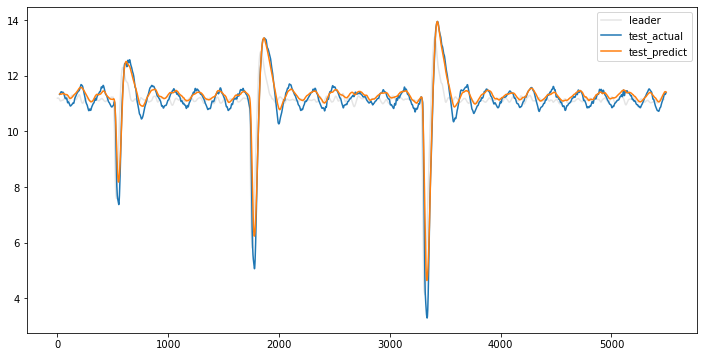

avg rel speed diff 1.9%


In [117]:
fig = plt.figure(figsize=(12, 6))
plt.plot(range(len(testX)), [t[0] for t in testX], label='leader',c='k',alpha=.1)
plt.plot(range(20, 20+len(testY), 1), testY, label='test_actual')
plt.plot(range(20, 20+len(prediction), 1), prediction,  label='test_predict')
plt.legend()
plt.show()
print(f'avg rel speed diff {round(np.mean(accs) * 100, 1)}%')